In [27]:
import numpy as np
import pandas as pd
import h5py
import matplotlib.pyplot as plt 
import pyqmc.api as pyq 

from scipy.optimize import curve_fit

myorange = plt.get_cmap('Oranges')(0.6)

In [2]:
system_name = "ortho_cavo3"
method = "dmc"
path = f"../data/{system_name}/{method}_sofk/"

d_n = pyq.read_mc_output(f"{path}/{method}_rdm1_state0.chk", warmup=40)
d_n_p1 = pyq.read_mc_output(f"{path}/{method}_rdm1_cdR_state0.chk", warmup=40)
d_n_m1 = pyq.read_mc_output(f"{path}/{method}_rdm1_cG_state0.chk", warmup=40)

# read in the qlist
with h5py.File(f"{path}/sofk_qlist.hdf5", 'r') as f:
    qlist = f["qlist"][()]

In [13]:
df_sofk = []

for iq, q in enumerate(qlist):
    q_val = np.linalg.norm(q)
    df_sofk.append({"q": q_val, 
                    "Sofk_n": d_n["SofkspinSq"][iq], 
                    "Sofk_n_err": d_n["SofkspinSq_err"][iq],
                    "Sofk_n+1": d_n_p1["SofkspinSq"][iq],
                    "Sofk_n+1_err": d_n_p1["SofkspinSq_err"][iq],
                    "Sofk_n-1": d_n_m1["SofkspinSq"][iq],
                    "Sofk_n-1_err": d_n_m1["SofkspinSq_err"][iq],
                    })

df_sofk = pd.DataFrame(df_sofk)
# sort by q
df_sofk = df_sofk.sort_values(by="q", ignore_index=True)


In [39]:
# smooth the data by shell averaging
def shell_average(df, q, dq):
    df["q_bin"] = (df["q"] // dq) * dq
    # shell average the Sofk value, and for the error, take the sqrt(sum...^2)
    df = df.groupby("q_bin").agg({
        "Sofk_n": "mean", "Sofk_n_err": lambda x: np.sqrt(np.sum(x**2))/len(x),
        "Sofk_n+1": "mean", "Sofk_n+1_err": lambda x: np.sqrt(np.sum(x**2))/len(x),
        "Sofk_n-1": "mean", "Sofk_n-1_err": lambda x: np.sqrt(np.sum(x**2))/len(x),
        })
    df = df.reset_index()
    df["q"] = df["q_bin"] + dq/2
    return df

# fit to (1-e^{-alpha*k^2})
def fit_func(x, alpha):
    return 1-np.exp(-alpha*x**2)


df_sofk = shell_average(df_sofk, "q", 0.1)

# only fit the data for q < 3
df_alpha = []
df_sofk_small = df_sofk[df_sofk["q"] < 3]
for nparticles in ["n", "n+1", "n-1"]:
    popt, pcov = curve_fit(fit_func, df_sofk_small["q"], df_sofk_small[f"Sofk_{nparticles}"], sigma=df_sofk_small[f"Sofk_{nparticles}_err"])
    print(nparticles, "alpha=", popt[0])
    df_alpha.append({"nparticles": nparticles, "alpha": popt[0], "alpha_err": np.sqrt(pcov[0,0])})

df_alpha = pd.DataFrame(df_alpha)

n alpha= 0.3314017022927481
n+1 alpha= 0.3253853335544181
n-1 alpha= 0.3327345869736864


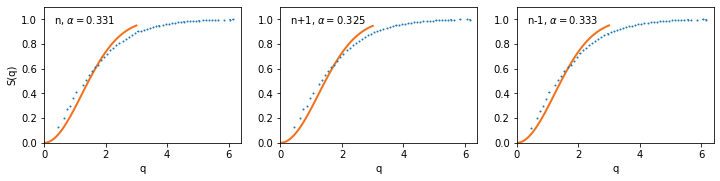

In [40]:
# plot the results vs the fit
q_grid = np.linspace(0, 3, 100)

fig, ax = plt.subplots(1, 3, figsize=(12, 2.5))
for i, nparticles in enumerate(["n", "n+1", "n-1"]):
    ax[i].errorbar(df_sofk["q"], df_sofk[f"Sofk_{nparticles}"], 
                   yerr = df_sofk[f"Sofk_{nparticles}_err"], 
                   label=nparticles, fmt="o", ms=1)
    ax[i].plot(q_grid,
               fit_func(q_grid, 
                float(df_alpha[df_alpha["nparticles"]==nparticles]["alpha"])), 
                color = myorange, lw=2)
    ax[i].annotate(f"{nparticles}, "+rf"$\alpha=${df_alpha[df_alpha['nparticles']==nparticles]['alpha'].values[0]:.3f}", xy=(0.05, 0.95), xycoords="axes fraction", ha="left", va="top")
    ax[i].set_ylim(0, 1.1)
    ax[i].set_xlim(0, 6.4)
    ax[i].set_xlabel("q")

ax[0].set_ylabel("S(q)")
fig.savefig("./ortho_cavo3_sofk.pdf", bbox_inches="tight")

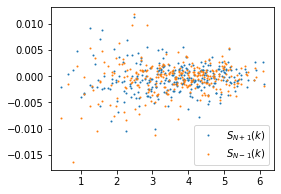

In [37]:
# plot the s+- as a function of q
# on one plot
fig, ax = plt.subplots(1, 1, figsize=(4, 3))
ax.errorbar(df_sofk["q"], df_sofk["Sofk_n+1"]-df_sofk["Sofk_n"], 
            #yerr=np.sqrt(df_sofk["Sofk_n+1_err"]**2+df_sofk["Sofk_n_err"]**2),
               fmt='o', ms=1, label=r"$S_{N+1}(k)$")

ax.errorbar(df_sofk["q"], df_sofk["Sofk_n-1"]-df_sofk["Sofk_n"], 
            #yerr=df_sofk["Sofk_n-1_err"],
                fmt='o', ms=1, label=r"$S_{N-1}(k)$")

# ax.set_xlim([0, 3])
# ax.set_ylim([-0.1, 0.6])
ax.legend()
